# Big Data Project
### Taylor Rohrich (trr2as) Alex Stern (acs4wq) Chirag Kulkarni (ck3fz)

This is the collection of all of our code for our Big Data Project. It is broken down into the following sections:
1. data import and preprocessing (2 PTS)
2. data splitting / sampling (1 PT)
3. exploratory data analysis, with at least 2 graphs (2 PTS)
4. model construction, with at least 3 models (3 PTS)
5. model evaluation (2 PTS)

## 1. data import and preprocessing (2 PTS)

### Combining these two CSV's is the only part done in pandas -- the rest is completely in pyspark

In [1]:
# initial imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [40]:
# Read base csv's
prices = pd.read_csv('prices_response.csv')
fundamentals = pd.read_csv('fundamentals.csv')

In [41]:
# Convert to datetime
prices['date']= pd.to_datetime(prices["date"])

In [42]:
# Get out specific statistics about the date
prices['quarter'] = prices['date'].dt.quarter
prices['year']=prices['date'].dt.year
prices['dayofweek']= prices['date'].dt.weekday
prices['month']= prices['date'].dt.month
prices['dayofmonth']= prices['date'].dt.day

In [43]:
# Check if a date is a holiday
cal = calendar()
holidays = cal.holidays()
prices['isholiday'] = prices['date'].isin(holidays).replace({True:1,False:0})
prices = prices.loc[~prices['futurePrice'].isna()]

In [44]:
# Drop index column
fundamentals.drop(columns=[fundamentals.columns[0]],inplace=True)
# Map and remove invalid column names
fundamentals.columns=fundamentals.columns.map(lambda x: "_".join(x.lower().replace(".","_").split(" ")))
# Rename invalid column names
fundamentals = fundamentals.rename(columns={'ticker_symbol':'symbol','sales,_general_and_admin_':'sales_general_and_admin_'})
# Convert to datetime, get out relevant summary statistics
fundamentals['date']= pd.to_datetime(fundamentals["period_ending"])
fundamentals['quarter'] = fundamentals['date'].dt.quarter
fundamentals['year']=fundamentals['date'].dt.year
# drop date column
fundamentals.drop(columns=['date'],inplace=True)

In [45]:
# Combine to dataframes
combined = prices.merge(fundamentals,on=['symbol','year','quarter'],how='left')

In [8]:
# Write out joined dataset to csv
combined.to_csv('stocks.csv',index=False)

In [2]:
# import psypark libraries
from pyspark.mllib.stat import Statistics
from pyspark.sql import SparkSession
from pyspark.sql.functions import col 
from pyspark.ml.feature import StandardScaler,Bucketizer
from pyspark.sql.types import FloatType
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml import Pipeline,PipelineModel
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
# import data types
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.util import DefaultParamsWritable,DefaultParamsReadable
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline, Transformer
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import time
import pandas as pd
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
spark = SparkSession.builder.getOrCreate()

In [3]:
# Read filename,cache
filename = 'stocks.csv'
df = spark.read.csv(filename, inferSchema=True, header = True)
df.cache()

DataFrame[date: timestamp, symbol: string, open: double, close: double, low: double, high: double, volume: double, dateLagged: timestamp, futurePrice: double, quarter: int, year: int, dayofweek: int, month: int, dayofmonth: int, isholiday: int, period_ending: timestamp, accounts_payable: double, accounts_receivable: double, add'l_income/expense_items: double, after_tax_roe: double, capital_expenditures: double, capital_surplus: double, cash_ratio: double, cash_and_cash_equivalents: double, changes_in_inventories: double, common_stocks: double, cost_of_revenue: double, current_ratio: double, deferred_asset_charges: double, deferred_liability_charges: double, depreciation: double, earnings_before_interest_and_tax: double, earnings_before_tax: double, effect_of_exchange_rate: double, equity_earnings/loss_unconsolidated_subsidiary: double, fixed_assets: double, goodwill: double, gross_margin: double, gross_profit: double, income_tax: double, intangible_assets: double, interest_expense: dou

#### Cast Columns to Different types

In [4]:
# Transformer will change datatype of column
class ChangeColumnType(Transformer, DefaultParamsWritable, DefaultParamsReadable):

    def __init__(self,inputCols=None, outputCol=None):
        super(ChangeColumnType, self).__init__()
        self.inputCols = inputCols

    def _transform(self, df):
        # for each input column, cast to a datatype
        for column, dataType in self.inputCols:
            df = df.withColumn(column, df[column].cast(dataType))
        return df

In [5]:
# Change date to an integer
changeColumnType = ChangeColumnType(inputCols = [('date','int')])

#### Filling NA's

In [6]:
# Columns with missing values
missingCols = ['accounts_payable', 'accounts_receivable',
       "add'l_income/expense_items", 'after_tax_roe', 'capital_expenditures',
       'capital_surplus', 'cash_ratio', 'cash_and_cash_equivalents',
       'changes_in_inventories', 'common_stocks', 'cost_of_revenue',
       'current_ratio', 'deferred_asset_charges', 'deferred_liability_charges',
       'depreciation', 'earnings_before_interest_and_tax',
       'earnings_before_tax', 'effect_of_exchange_rate',
       'equity_earnings/loss_unconsolidated_subsidiary', 'fixed_assets',
       'goodwill', 'gross_margin', 'gross_profit', 'income_tax',
       'intangible_assets', 'interest_expense', 'inventory', 'investments',
       'liabilities', 'long-term_debt', 'long-term_investments',
       'minority_interest', 'misc__stocks', 'net_borrowings', 'net_cash_flow',
       'net_cash_flow-operating', 'net_cash_flows-financing',
       'net_cash_flows-investing', 'net_income', 'net_income_adjustments',
       'net_income_applicable_to_common_shareholders',
       'net_income-cont__operations', 'net_receivables', 'non-recurring_items',
       'operating_income', 'operating_margin', 'other_assets',
       'other_current_assets', 'other_current_liabilities', 'other_equity',
       'other_financing_activities', 'other_investing_activities',
       'other_liabilities', 'other_operating_activities',
       'other_operating_items', 'pre-tax_margin', 'pre-tax_roe',
       'profit_margin', 'quick_ratio', 'research_and_development',
       'retained_earnings', 'sale_and_purchase_of_stock',
       'sales_general_and_admin_',
       'short-term_debt_/_current_portion_of_long-term_debt',
       'short-term_investments', 'total_assets', 'total_current_assets',
       'total_current_liabilities', 'total_equity', 'total_liabilities',
       'total_liabilities_&_equity', 'total_revenue', 'treasury_stock',
       'for_year', 'earnings_per_share', 'estimated_shares_outstanding']
#get output names
output = [f'{column}_out' for column in missingCols]
# Create imputer to fill na's
imputer = Imputer(inputCols=missingCols, outputCols=missingCols)
# Fit on data
model = imputer.fit(df)

#### Convert String Ticker to Index

In [7]:
# Create stringindexer to convert symbol to index
indexer = StringIndexer(inputCol="symbol", outputCol="symbolIndex")
# Fit on df
indexer.fit(df)

StringIndexer_6fa7062d8332

#### Create Response

In [8]:
# Helper function for response: 1 if stock improved otherwise 0
def stockImproved(s):
    return 1 if s > 0 else 0
# Transformer to create response variable
class CreateResponseVariable(Transformer, DefaultParamsWritable, DefaultParamsReadable):
    def __init__(self,inputCol=None, outputCol=None):
        super(CreateResponseVariable, self).__init__()

    def _transform(self, df):
        # Create difference column
        df= df.withColumn('difference',col('futurePrice')-col('close'))
        # Calculate if stock improved
        stockImproved_udf = udf(stockImproved)
        # Create label column with if stock improved
        df = df.withColumn("label", stockImproved_udf('difference').cast('integer'))
        return df

In [9]:
# Transformer
responseVariable = CreateResponseVariable()

#### One Hot Encode

In [10]:
# One Hot encode Transformer for symbolIndex
encoder = OneHotEncoder(inputCol="symbolIndex", outputCol="symbolVec")

#### Get Features

In [11]:
# Variables to keep
vars_to_keep = ["label",'open','close',
               'year','dayofweek','dayofmonth','month','date','symbolIndex','gross_profit','long-term_debt','close']
# Extract features
features = [column for column in vars_to_keep if column !='label']

# Features transformer
getFeatures = VectorAssembler(inputCols=features, outputCol="features")

## 2. data splitting / sampling (1 PT)

#### Train Test Split

In [12]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = df.randomSplit([0.7, 0.3])


## 3. exploratory data analysis, with at least 2 graphs (2 PTS)

### Number of Records

In [66]:
len(combined)

814755

### Number of Columns

In [67]:
len(combined.columns)

93

### Statistical Summary of Response Variable

In [68]:
# Our response is a binary of if a stock increases or not in 2 months time
response = pd.Series(np.where(combined['futurePrice'] - combined['close'] > 0, 1,0))
response.value_counts()

1    469512
0    345243
dtype: int64

In [69]:
combined['label'] = response

### Statistical Summary of (Top 10) Predictor Variables

In [104]:
# Selected Columns
selectedCols = ['date', 'symbol', 'open', 'volume','close',
       'year','cash_ratio','gross_profit','net_income','long-term_debt']

In [71]:
parsed =combined[selectedCols]

#### Numerical Columns

In [72]:
parsed.describe()

,open,volume,close,year,cash_ratio,gross_profit,net_income,long-term_debt
count,814755.000000,8.147550e+05,814755.000000,814755.000000,85811.000000,1.026520e+05,1.026520e+05,1.026520e+05
mean,70.614875,5.435131e+06,70.636948,2013.021495,74.315740,7.243997e+09,1.727893e+09,8.567070e+09
std,83.306007,1.251702e+07,83.301740,1.990734,101.701142,1.374504e+10,4.064660e+09,2.784023e+10
min,0.850000,0.000000e+00,0.860000,2010.000000,0.000000,-1.264700e+10,-2.352800e+10,0.000000e+00
25%,33.775044,1.225500e+06,33.790001,2011.000000,17.000000,1.598600e+09,3.550000e+08,1.144100e+09
50%,52.619999,2.484900e+06,52.660000,2013.000000,41.000000,3.001000e+09,6.898000e+08,3.386000e+09
75%,79.699997,5.241550e+06,79.720001,2015.000000,90.000000,6.939000e+09,1.697000e+09,7.816000e+09
max,1584.439941,8.596434e+08,1578.130005,2016.000000,1041.000000,1.494530e+11,5.339400e+10,4.291940e+11


#### Categorical Column

In [73]:
# See output of ticker values
combined['symbol'].value_counts()

PXD     1687
BBT     1687
PFG     1687
APD     1687
KLAC    1687
        ... 
PYPL     348
HPE      275
CSRA     256
WLTW     226
FTV      104
Name: symbol, Length: 501, dtype: int64

### Helpful Graphs

#### Correlation Matrix of the Top 10 Predictors

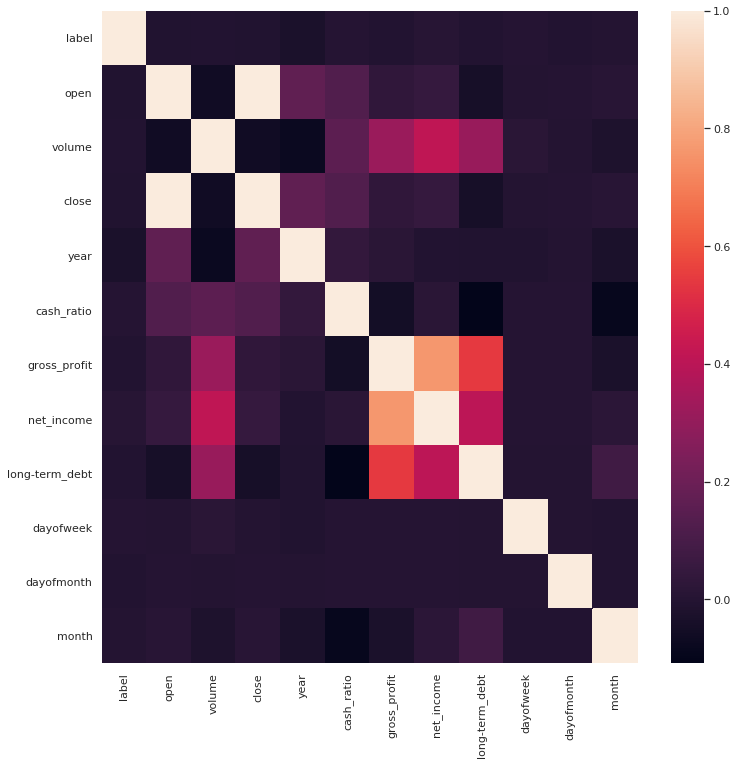

In [110]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12,12)})
# Correlation matrix
matCols = ['label']+selectedCols + ['dayofweek', 'dayofmonth', 'month','date']
corr = combined[matCols].corr()
sns.heatmap(corr)

#### Histogram of Gross Profit

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'amount')

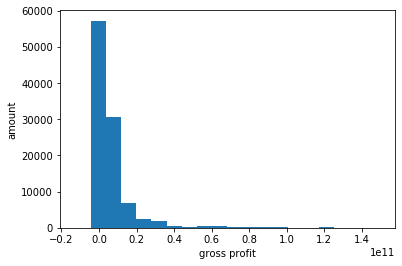

In [83]:
plt.hist(parsed['gross_profit'],bins=20)
plt.xlabel('gross profit')
plt.ylabel('amount')

From the output above, we see that the gross profit of companies of stocks has extreme right skew.

### Average Open By Day

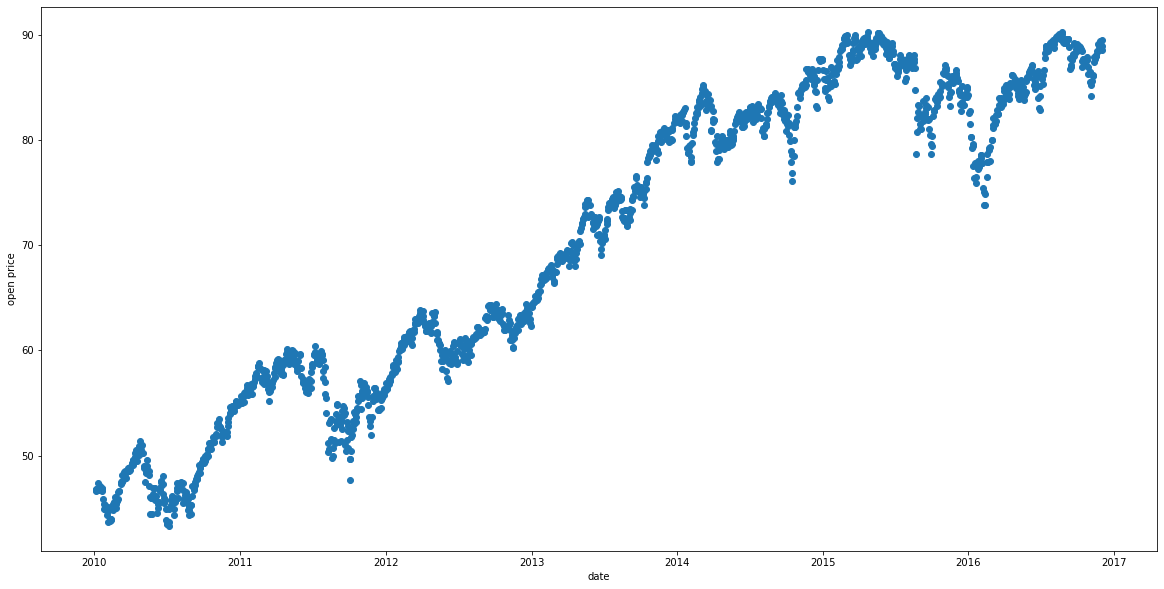

In [84]:
# Group by day
year_breakdown = combined.groupby(['date'])['open'].mean().reset_index()
plt.figure(figsize=(20,10))
plt.scatter(year_breakdown['date'],year_breakdown['open'])
plt.xlabel('date')
plt.ylabel('open price')
plt.show()

From the output above, we can see the general trend in the market over time.

### Specific Stocks

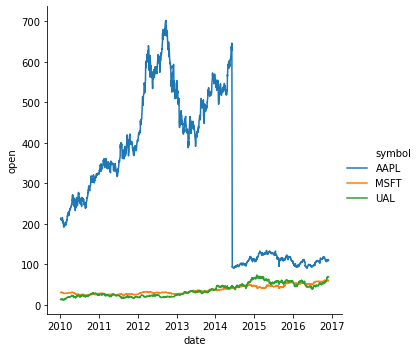

In [79]:
import seaborn as sns
# We see a split here
sns.relplot(x='date', y='open', hue='symbol', kind='line', data=prices[prices['symbol'].isin(['AAPL', 'UAL', 'MSFT'])]);

From the output above, we can see what data looks like for specific stocks over time. We can see a split in AAPL around 2014.

### Average Net Income By Year Quarter

In [86]:
# Group by year, quarter for net income
year_breakdown = combined.groupby(['year','quarter'])['net_income'].mean().reset_index()

In [87]:
x = year_breakdown['year'].astype(str)+ "Q" + year_breakdown['quarter'].astype(str)

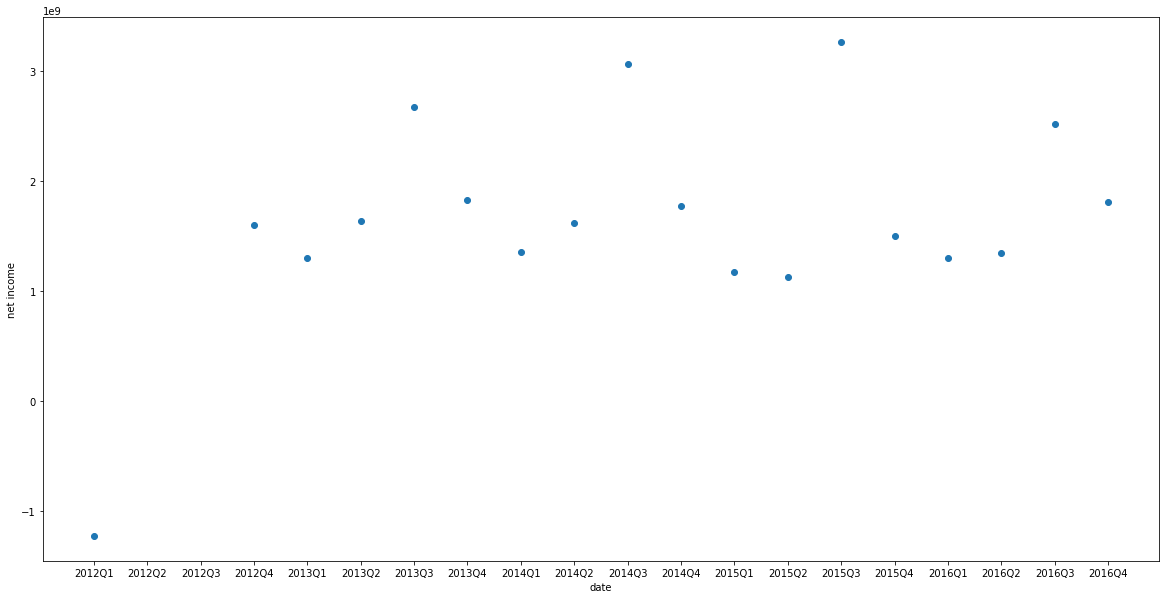

In [88]:
plt.figure(figsize=(20,10))
plt.scatter(x,year_breakdown['net_income'])
plt.xlabel('date')
plt.ylabel('net income')
plt.show()

From the output above, we can see a general increase in the net income of the companies of stocks over time.

## 4. model construction, with at least 3 models (3 PTS)

In [18]:
# Helper function to calculate accuracy
def getAccuracy(predictions):
    return predictions.rdd.map(lambda lp: (lp['label'] ==lp['prediction'])).sum() / predictions.count()

### 1. Gradient Boosted Tree

In [16]:

# Train a GBT model.
gbt = GBTClassifier(featuresCol="features",labelCol = 'label', maxIter=10)
# Chain indexer and GBT in a Pipeline
pipeline = Pipeline(stages=[changeColumnType,imputer,indexer,responseVariable,encoder,getFeatures,gbt])

### Parameter Tuning

In [20]:

# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxBins, [550, 700]) \
    .addGrid(gbt.maxDepth,[5,10]) \
    .build()

print('len(paramGrid): {}'.format(len(paramGrid)))

# Treat the Pipeline as an Estimator, wrapping it in a TrainValidation instance.
trainval =  TrainValidationSplit(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator()
                         )


len(paramGrid): 4


In [21]:
# Run cross-validation, and choose the best set of parameters. Print the training time.
t0 = time.time()

bestGBTModel = trainval.setParallelism(4).fit(trainingData) # train 4 models in parallel
print("train time:", time.time() - t0)

# Make predictions on test documents
prediction = bestRandomForestModel.transform(testData)

train time: 624.3759710788727


In [23]:
#https://stackoverflow.com/questions/51230726/extract-results-from-crossvalidator-with-paramgrid-in-pyspark
params = [{p.name: v for p, v in m.items()} for m in bestGBTModel.getEstimatorParamMaps()]

In [25]:
# Print out the metrics and corresponding AUC
pd.DataFrame.from_dict([
    {bestGBTModel.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, bestGBTModel.validationMetrics)
])

,areaUnderROC,maxBins,maxDepth
0,0.731846,550,5
1,0.845648,550,10
2,0.738461,700,5
3,0.831500,700,10


In [26]:
# Get accuracy on test set
predictions = bestGBTModel.transform(testData)
getAccuracy(predictions)

0.759914496029297

In [ ]:
# save best model
bestGBTModel.save("tmp/best-tree-model")

### Size

In [97]:
!du -sh tmp/best-tree-model

1.4M	tmp/best-tree-model


In [95]:
pipelineModel = Pipeline.load("tmp/best-tree-model")

### 2. Logistic Regression

In [29]:
# Create logistic regression
lr = LogisticRegression(featuresCol="features",labelCol = 'label')
# Create pipeline
pipeline = Pipeline(stages=[changeColumnType,imputer,indexer,responseVariable,encoder,getFeatures,lr])


In [30]:
# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10,20, 30]) \
    .addGrid(lr.elasticNetParam,[0.1,0.5,0.9]) \
    .build()

print('len(paramGrid): {}'.format(len(paramGrid)))

# Treat the Pipeline as an Estimator, wrapping it in a TrainValidation instance.
trainVal = TrainValidationSplit(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator())


len(paramGrid): 9


In [31]:
# Run cross-validation, and choose the best set of parameters. Print the training time.
t0 = time.time()

bestLrModel = trainVal.setParallelism(4).fit(trainingData) # train 4 models in parallel
print("train time:", time.time() - t0)



train time: 475.09101152420044


In [33]:

#https://stackoverflow.com/questions/51230726/extract-results-from-crossvalidator-with-paramgrid-in-pyspark
params = [{p.name: v for p, v in m.items()} for m in bestLrModel.getEstimatorParamMaps()]
# Print out metrics and AUC
pd.DataFrame.from_dict([
    {bestLrModel.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, bestLrModel.validationMetrics)
])

,areaUnderROC,maxIter,elasticNetParam
0,0.517932,10,0.1
1,0.517932,10,0.5
2,0.517932,10,0.9
3,0.517905,20,0.1
4,0.517905,20,0.5
5,0.517905,20,0.9
6,0.518338,30,0.1
7,0.518338,30,0.5
8,0.518338,30,0.9


In [34]:
# Make predictions on test documents.
prediction = bestLrModel.transform(testData)
getAccuracy(prediction)

0.5764120212370283

### 3: Deep Learning

In [29]:
# Set up layers
layers = [11, 5, 4, 2]
# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(layers=layers, seed=1234)

In [30]:
# Create pipeline
pipeline = Pipeline(stages=[changeColumnType,imputer,indexer,responseVariable,encoder,getFeatures,trainer])


In [31]:
# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(trainer.maxIter, [10,50,100,150]) \
    .addGrid(trainer.blockSize,[64,128,256]) \
    .build()

print('len(paramGrid): {}'.format(len(paramGrid)))

# Treat the Pipeline as an Estimator, wrapping it in a TrainValidation instance.
trainVal = TrainValidationSplit(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator())



len(paramGrid): 12


In [32]:
# Run cross-validation, and choose the best set of parameters. Print the training time.
t0 = time.time()

bestMLPCModel = trainVal.setParallelism(4).fit(trainingData) # train 4 models in parallel
print("train time:", time.time() - t0)



train time: 4940.933402776718


In [33]:
#https://stackoverflow.com/questions/51230726/extract-results-from-crossvalidator-with-paramgrid-in-pyspark
params = [{p.name: v for p, v in m.items()} for m in bestMLPCModel.getEstimatorParamMaps()]
# Get metrics and AUC
pd.DataFrame.from_dict([
    {bestMLPCModel.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, bestMLPCModel.validationMetrics)
])

,areaUnderROC,maxIter,blockSize
0,0.503215,10,64
1,0.503215,10,128
2,0.503215,10,256
3,0.503215,50,64
4,0.503215,50,128
5,0.503214,50,256
6,0.503215,100,64
7,0.503215,100,128
8,0.503214,100,256
9,0.503215,150,64


In [35]:
# Make predictions on test set, get accuracy
prediction = bestMLPCModel.transform(testData)
getAccuracy(prediction)

0.575877001943309

## 5. model evaluation (2 PTS)

### a. Evaluate relevant metrics (for hypertuned models)

In [29]:
# Recreate Models with tuned hyperparameters
bestBt = GBTClassifier(featuresCol="features",labelCol = 'label', maxIter=10,maxBins=550,maxDepth=10)
pipelineBt = Pipeline(stages=[changeColumnType,imputer,indexer,responseVariable,encoder,getFeatures,bestBt])

bestLr = LogisticRegression(featuresCol="features",labelCol = 'label',elasticNetParam = 0.5, maxIter=30)
pipelineLr = Pipeline(stages=[changeColumnType,imputer,indexer,responseVariable,encoder,getFeatures,bestLr])

bestMlpc = MultilayerPerceptronClassifier(layers=[11, 5, 4, 2], seed=1234,maxIter=10,blockSize=64)
pipelineMlpc = Pipeline(stages=[changeColumnType,imputer,indexer,responseVariable,encoder,getFeatures,bestMlpc])

# Fit models on training data
bestBtModel = pipelineBt.fit(trainingData)
bestLrModel = pipelineLr.fit(trainingData)
bestMlpcModel = pipelineMlpc.fit(trainingData)

# Get Predictions for each of the models
predBt = bestBtModel.transform(testData)
predLr = bestLrModel.transform(testData)
predMlpc = bestMlpcModel.transform(testData)
predBt.cache()
predLr.cache()
predMlpc.cache()

DataFrame[date: int, symbol: string, open: double, close: double, low: double, high: double, volume: double, dateLagged: timestamp, futurePrice: double, quarter: int, year: int, dayofweek: int, month: int, dayofmonth: int, isholiday: int, period_ending: timestamp, accounts_payable: double, accounts_receivable: double, add'l_income/expense_items: double, after_tax_roe: double, capital_expenditures: double, capital_surplus: double, cash_ratio: double, cash_and_cash_equivalents: double, changes_in_inventories: double, common_stocks: double, cost_of_revenue: double, current_ratio: double, deferred_asset_charges: double, deferred_liability_charges: double, depreciation: double, earnings_before_interest_and_tax: double, earnings_before_tax: double, effect_of_exchange_rate: double, equity_earnings/loss_unconsolidated_subsidiary: double, fixed_assets: double, goodwill: double, gross_margin: double, gross_profit: double, income_tax: double, intangible_assets: double, interest_expense: double, i

In [31]:
# Compute raw scores on the test set
BtPredictionAndLabels = predBt.rdd.map(lambda lp: (float(lp.prediction),float(lp.label)))
LrPredictionAndLabels = predLr.rdd.map(lambda lp: (float(lp.prediction),float(lp.label)))
MlpcPredictionAndLabels = predMlpc.rdd.map(lambda lp: (float(lp.prediction),float(lp.label)))
BtPredictionAndLabels.cache()
LrPredictionAndLabels.cache()
MlpcPredictionAndLabels.cache()

PythonRDD[787] at RDD at PythonRDD.scala:53

In [132]:
# Helper function to get metrics
def getMetrics(predLabels):
    metricsBin = BinaryClassificationMetrics(predLabels)
    # auc
    auc = metricsBin.areaUnderROC
    metricsMulti = MulticlassMetrics(predLabels)
    # accuracy
    accuracy = metricsMulti.accuracy
    # precision
    precision = metricsMulti.precision(1)
    # recall
    recall = metricsMulti.recall(1)
    # f1 score
    f1score = metricsMulti.weightedFMeasure()
    # confusion matrix
    confusionMatrix = metricsMulti.confusionMatrix()
    return pd.DataFrame([[auc,accuracy,precision,recall,f1score]],columns=['auc','accuracy','precision','recall','f1score']), pd.DataFrame(confusionMatrix.toArray(),index=['actual 0','actual 1'],columns=['predicted 0','predicted 1'])

In [133]:
# get Logistic Regression Metrics
pd1, mat = getMetrics(LrPredictionAndLabels)

In [134]:
pd1

,auc,accuracy,precision,recall,f1score
0,0.5,0.575036,0.575036,1.0,0.419884


In [135]:
mat

,predicted 0,predicted 1
actual 0,0.0,104067.0
actual 1,0.0,140817.0


In [136]:
# Get Gradient Boosted Tree Metrics
pd1, mat = getMetrics(BtPredictionAndLabels)

In [137]:
pd1

,auc,accuracy,precision,recall,f1score
0,0.759694,0.779144,0.764874,0.889303,0.773794


In [138]:
mat

,predicted 0,predicted 1
actual 0,65571.0,38496.0
actual 1,15588.0,125229.0


In [139]:
# Get Multilayer Perceptron Metrics
pd1, mat = getMetrics(MlpcPredictionAndLabels)

In [140]:
pd1

,auc,accuracy,precision,recall,f1score
0,0.5,0.575036,0.575036,1.0,0.419884


In [141]:
mat

,predicted 0,predicted 1
actual 0,0.0,104067.0
actual 1,0.0,140817.0


### Champion Model

Because of the output above, The Gradient Boosted Tree is our champion model, with a test set accuracy of 77.9%.

### b. Sensitivity Analysis

In [19]:
# Custom Transformer to do sensitivity analysis
class SensitivityAnalysis(Transformer, DefaultParamsWritable, DefaultParamsReadable):
    def __init__(self,inputCol=None, outputCol=None):
        super(SensitivityAnalysis, self).__init__()
        self.inputCol = inputCol

    def _transform(self, df):
        # Change the specified variable by one standard deviation
        df_stats = df.select(
        _mean(col(self.inputCol)).alias('mean'),
        _stddev(col(self.inputCol)).alias('std')
            ).collect()
        std = df_stats[0]['std']
        df = df.withColumn(self.inputCol,col(self.inputCol)+ std)
        return df

In [20]:
# Helper function to run sensitivity analysis for specified variables
def runSensitivityAnalysis(variables):
    # For each variable...
    rows = []
    index=[]
    columns = ['LR','DL','GBT']
    for variable in variables:
        # Create Sensitivity Analysis Transformer
        sensitivity = SensitivityAnalysis(variable)
        # Recreate Best Pipelines but with Sensitivity Analysis
        bestBt = GBTClassifier(featuresCol="features",labelCol = 'label', maxIter=10,maxBins=550,maxDepth=10)
        pipelineBt = Pipeline(stages=[changeColumnType,imputer,indexer,responseVariable,sensitivity,encoder,getFeatures,bestBt])

        bestLr = LogisticRegression(featuresCol="features",labelCol = 'label',elasticNetParam = 0.5, maxIter=30)
        pipelineLr = Pipeline(stages=[changeColumnType,imputer,indexer,responseVariable,sensitivity,encoder,getFeatures,bestLr])

        bestMlpc = MultilayerPerceptronClassifier(layers=[11, 5, 4, 2], seed=1234,maxIter=10,blockSize=64)
        pipelineMlpc = Pipeline(stages=[changeColumnType,imputer,indexer,responseVariable,sensitivity,encoder,getFeatures,bestMlpc])
        
        # Train Models
        bestBtModel = pipelineBt.fit(trainingData)
        bestLrModel = pipelineLr.fit(trainingData)
        bestMlpcModel = pipelineMlpc.fit(trainingData)
        
        # Get Accuracy
        predBt = getAccuracy(bestBtModel.transform(testData))
        predLr = getAccuracy(bestLrModel.transform(testData))
        predMlpc = getAccuracy(bestMlpcModel.transform(testData))
        rows.append([predLr,predMlpc,predBt])
        index.append(variable)
    return pd.DataFrame(rows,columns=columns,index=index)



In [21]:
# Run sensitivty analysis on the specified variables
sensRes = runSensitivityAnalysis(['gross_profit','long-term_debt','open','close'])

In [22]:
sensRes

,LR,DL,GBT
gross_profit,0.576032,0.576032,0.781389
long-term_debt,0.576032,0.576032,0.781728
open,0.576032,0.576032,0.781058
close,0.576032,0.576032,0.781585


From the output above, we see that as we add a standard deviation of specific columns of our models by one, our models (especially our champion model) retain similiar test set accuracies to those with non-adjusted columns.

In [98]:
# Save notebook as PDF document
!jupyter nbconvert --to pdf `pwd`/*.ipynb

[NbConvertApp] Converting notebook /sfs/qumulo/qhome/trr2as/ds5559/project/big_data_cleaning.ipynb to pdf
[NbConvertApp] Support files will be in big_data_cleaning_files/
[NbConvertApp] Making directory ./big_data_cleaning_files
[NbConvertApp] Making directory ./big_data_cleaning_files
[NbConvertApp] Making directory ./big_data_cleaning_files
[NbConvertApp] Making directory ./big_data_cleaning_files
[NbConvertApp] Making directory ./big_data_cleaning_files
[NbConvertApp] Writing 67678 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 144370 bytes to /sfs/qumulo/qhome/trr2as/ds5559/project/big_data_cleaning.pdf
[NbConvertApp] Converting notebook /sfs/qumulo/qhome/trr2as/ds5559/project/lag_model